# RE:从零开始的现代卷积神经网络

## RE:从零开始的AlexNet深度卷积神经网络

### 架构

![image](https://zh-v2.d2l.ai/_images/alexnet.svg)

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。
- AlexNet比相对较小的LeNet5要深得多。AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。

- AlexNet使用ReLU而不是sigmoid作为其激活函数。

### 模型设计

在AlexNet的第一层，卷积窗口的形状是$ 11 \times $。由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。 第二层中的卷积窗口形状被缩减为$5 \times 5$，然后是$3 \times 3$ 。 此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为$3 \times 3$、步幅为2的最大汇聚层。 而且，AlexNet的卷积通道数目是LeNet的10倍。
在最后一个卷积层后有两个全连接层，分别有4096个输出。 这两个巨大的全连接层拥有将近1GB的模型参数。 由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。 幸运的是，现在GPU显存相对充裕，所以现在很少需要跨GPU分解模型

### 激活函数

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。 一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。 另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。 当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。 相反，ReLU激活函数在正区间的梯度总是1。 因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

### 容量控制和预处理

AlexNet通过暂退法控制全连接层的模型复杂度，而LeNet只使用了权重衰减。 为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。 这使得模型更健壮，更大的样本量有效地减少了过拟合。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    nn.Linear(6400,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,10)
)

In [3]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [2]:
batch_size = 128
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)

loss 0.328, train acc 0.880, test acc 0.879
1037.3 examples/sec on cuda:0


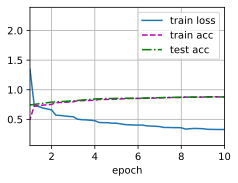

In [3]:
lr,num_epochs=0.01,10
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

## RE:从零开始的VGG块的网络

### VGG块

经典卷积神经网络的基本组成部分是下面的这个序列：

- 带填充以保持分辨率的卷积层；

- 非线性激活函数，如ReLU；

- 汇聚层，如最大汇聚层。

In [4]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### VGG网络

![image](https://zh-v2.d2l.ai/_images/vgg.svg)

In [5]:
conv_arch = ((1,64),(1,128),(2,256),(2,512),(2,512))

In [6]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks,nn.Flatten(),
        nn.Linear(out_channels * 7 * 7,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,10)
    )

net = vgg(conv_arch)

In [7]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [8]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.177, train acc 0.936, test acc 0.919
656.7 examples/sec on cuda:0


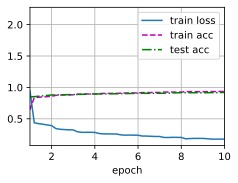

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## RE:从零开始的NiN网络中的网络

### NiN块

![image](https://zh-v2.d2l.ai/_images/nin.svg)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。 另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。 NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。 如果我们将权重连接到每个空间位置，我们可以将其视为$1 \times 1$
卷积层，或作为在每个像素位置上独立作用的全连接层。 从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。
上图说明了VGG和NiN及它们的块之间主要架构差异。 NiN块以一个普通卷积层开始，后面是两个$1 \times 1$
的卷积层。这两个$1 \times 1$
卷积层充当带有ReLU激活函数的逐像素全连接层。 第一层的卷积窗口形状通常由用户设置。 随后的卷积窗口形状固定为$1 \times 1$
。

In [10]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

### NiN模型

In [11]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [13]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.407, train acc 0.850, test acc 0.855
1002.5 examples/sec on cuda:0


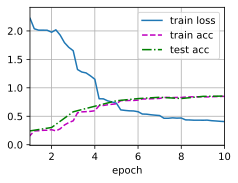

In [14]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## RE:从零开始的GoogLeNet含并行连接的网络

GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。 毕竟，以前流行的网络使用小到$1 \times 1 $
，大到$11 \times 11$的卷积核。 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。 

### Inception块

![Inception块结构](https://zh-v2.d2l.ai/_images/inception.svg)

Inception块由四条并行路径组成。 前三条路径使用窗口大小为$1 \times 1$、$3 \times 3$和$5 \times 5 $的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行$1 \times 1$卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用$3 \times 3$最大汇聚层，然后使用$1 \times 1$卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [1]:
import torch
from torch import nn
from torch.nn import functional as f
from d2l import torch as d2l

In [2]:
class Inception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels,c1,kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        self.p3_1 = nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2 = nn.Conv2d(in_channels,c4,kernel_size=1)

    def forward(self,x):
        p1 = f.relu(self.p1_1(x))
        p2 = f.relu(self.p2_2(f.relu(self.p2_1(x))))
        p3 = f.relu(self.p3_2(f.relu(self.p3_1(x))))
        p4 = f.relu(self.p4_2(f.relu(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4),dim=1)

### GoogLeNet模型

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

<div align="center">

![GoogLeNet模块结构](https://zh-v2.d2l.ai/_images/inception-full.svg)

*GoogLeNet模块结构示意图*

</div>

In [3]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [4]:
b2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64,192,kernel_size=3,padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.269, train acc 0.896, test acc 0.883
1012.5 examples/sec on cuda:0


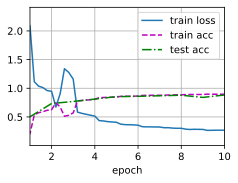

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 批量规范化

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。 本节将介绍批量规范化，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。

### 训练深层网络

数据预处理的方式通常会对最终结果产生巨大影响。  使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。 直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。

更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。 接下来，我们应用比例系数和比例偏移。 正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

请注意，如果我们尝试使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。 这是因为在减去均值之后，每个隐藏单元将为0。 所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 请注意，在应用批量规范化时，批量大小的选择可能比没有批量规范化时更重要。

从形式上来说，用$\mathbf{x} \in \mathcal{B}$
表示一个来自小批量$\mathcal{B} $
的输入，批量规范化$BN$
根据以下表达式转换$\mathbf{x}$
：

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta} $$

$\hat{\boldsymbol{\mu}}_\mathcal{B}$是小批量$\mathcal{B}$的样本均值，$\hat{\boldsymbol{\sigma}}_\mathcal{B}$是小批量$\mathcal{B}$的样本标准差。 应用标准化后，生成的小批量的平均值为0和单位方差为1。 由于单位方差（与其他一些魔法数）是一个主观的选择，因此我们通常包含拉伸参数$\boldsymbol{\gamma}$和偏移参数$\boldsymbol{\beta}$，它们的形状与$\mathbf{x}$相同。 请注意，$\boldsymbol{\gamma}$和$\boldsymbol{\beta}$是需要与其他模型参数一起学习的参数。

由于在训练过程中，中间层的变化幅度不能过于剧烈，而批量规范化将每一层主动居中，并将它们重新调整为给定的平均值和大小（通过$\hat{\boldsymbol{\mu}}_\mathcal{B}$
和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。

从形式上来看，我们计算出$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$，如下所示：

$$\begin{split}\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}\end{split} $$

我们在方差估计值中添加一个小的常量$\epsilon > 0$，以确保我们永远不会尝试除以零，即使在经验方差估计值可能消失的情况下也是如此。估计值$\hat{\boldsymbol{\mu}}_\mathcal{B}$和$ {\hat{\boldsymbol{\sigma}}_\mathcal{B}}$通过使用平均值和方差的噪声估计来抵消缩放问题。乍看起来，这种噪声是一个问题，而事实上它是有益的。

事实证明，这是深度学习中一个反复出现的主题。 由于尚未在理论上明确的原因，优化中的各种噪声源通常会导致更快的训练和较少的过拟合：这种变化似乎是正则化的一种形式。

另外，批量规范化层在”训练模式“（通过小批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。 而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。

## 批量规范化层

批量规范化和其他层之间的一个关键区别是，由于批量规范化在完整的小批量上运行，因此我们不能像以前在引入其他层时那样忽略批量大小。 我们在下面讨论这两种情况：全连接层和卷积层，他们的批量规范化实现略有不同。

### 全连接层

通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。

设全连接层的输入为$x$，权重参数和偏置参数分别为$\mathbf{W}$和$\mathbf{b}$，激活函数为$\phi$，批量规范化的运算符为$\mathrm{BN}$。 那么，使用批量规范化的全连接层的输出的计算详情如下：

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

### 卷积层

同样，对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。 当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸和偏移参数，这两个参数都是标量。 假设我们的小批量包含$m$个样本，并且对于每个通道，卷积的输出具有高度$p$和宽度$q$。 那么对于卷积层，我们在每个输出通道的$m \cdot p \cdot q$
个元素上同时执行每个批量规范化。 因此，在计算平均值和方差时，我们会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

### 预测阶段

正如我们前面提到的，批量规范化在训练模式和预测模式下的行为通常不同。 首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。 其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。 一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。 可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不一样的。

### RE:从零开始的批量规范化

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean)/torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim = (0,2,3),keepdim=True)
            var = ((X - mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum)*mean
        moving_var = momentum * moving_var + (1.0 - momentum)*var
    Y = gamma * X_hat + beta
    return Y,moving_mean.data,moving_var.data
        

In [18]:
class BatchNorm(nn.Module):

    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
         
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
       
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
         
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [19]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.268, train acc 0.901, test acc 0.831
11296.3 examples/sec on cuda:0


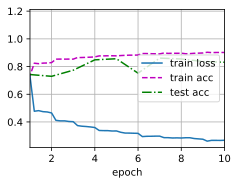

In [20]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([3.3077, 2.4899, 1.7843, 3.5318, 2.8992, 2.5331], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-2.1146, -2.7807,  0.1914, -2.2960, -2.6736, -0.8523], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [22]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.262, train acc 0.904, test acc 0.793
20043.0 examples/sec on cuda:0


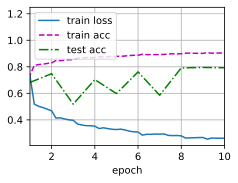

In [23]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## RE:从零开始的ResNet残差网络

### 数学基础之函数类

假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。 对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。 现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。 相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。 例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？ 唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。 换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。 然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。 事实上，$f^*_{\mathcal{F}'}$可能更糟，对于非嵌套函数类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。 相反嵌套函数类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![image](https://zh-v2.d2l.ai/_images/functionclasses.svg)

对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（$f^*$）。这种现象在嵌套函数类中不会发生。

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。 对于深度神经网络，如果我们能将新添加的层训练成恒等映射$f(\mathbf{x}) = \mathbf{x}$
，新模型和原模型将同样有效。 同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

 残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。 于是，残差块（residual blocks）便诞生了.

### 残差块

![image](https://zh-v2.d2l.ai/_images/residual-block.svg)

ResNet沿用了VGG完整的$3 \times 3$卷积层设计。 残差块里首先有2个有相同输出通道数的$1 \times 1$卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。 如果想改变通道数，就需要引入一个额外的$3 \times 3$卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

![image](https://zh-v2.d2l.ai/_images/resnet-block.svg)

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1 \times 1$卷积层）。 加上第一个$7 \times 7$卷积层和最后一个全连接层，共有18层。 因此，这种模型通常被称为ResNet-18。 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

![image](https://zh-v2.d2l.ai/_images/resnet18.svg)

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.030, train acc 0.990, test acc 0.919
1722.5 examples/sec on cuda:0


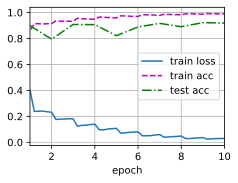

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 64 #原文是256，我这台电脑显存直接炸了
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## RE:从零开始的DenseNet稠密连接网络

### 从ResNet到DenseNet

我们仿照泰勒展开式的样子，将ResNet展开为

$$ f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

这边是DenseNet

![image](https://zh-v2.d2l.ai/_images/densenet-block.svg)

ResNet和DenseNet的关键区别在于，DenseNet输出是连接（用图中的$[,]$表示）而不是如ResNet的简单相加。 因此，在应用越来越复杂的函数序列后，我们执行从$\mathbf{x}$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。 实现起来非常简单：我们不需要添加术语，而是将它们连接起来。 DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。 

![image](https://zh-v2.d2l.ai/_images/densenet.svg)

稠密网络主要由2部分构成：稠密块和过渡层。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

### 稠密块

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels,num_channels):
    return nn.Sequential(
    nn.BatchNorm2d(input_channels),nn.ReLU(),
    nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1))

In [11]:
class DenseBlock(nn.Module):
    def __init__(self,num_convs,input_channels,num_channels):
        super(DenseBlock,self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels,num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self,X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X,Y),dim=1)
        return X

In [12]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 过渡层

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过$1 \times 1$
卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [13]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [14]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet模型

In [15]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [16]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [17]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

loss 0.119, train acc 0.955, test acc 0.918
1313.2 examples/sec on cuda:0


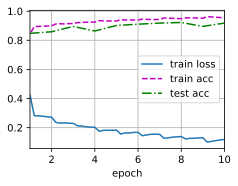

In [18]:
lr, num_epochs, batch_size = 0.1, 10, 64 #原文为256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())